In [1]:
import pandas as pd
import numpy as np
from modeling import Transfer_Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


from tensorflow.keras.metrics import RootMeanSquaredError

# Variables from config file
import sys
sys.path.append('/home/yusukemh/github/yusukemh/StatisticalDownscaling/codes/')
from config import BASE_DIR, C_SINGLE, C_GRID, C_COMMON
# enable autoreload
%load_ext autoreload
%autoreload 2

2022-07-05 22:56:37.844744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/devel/PCRE/8.41-GCCcore-7.3.0/lib:/opt/apps/software/lang/Perl/5.28.0-GCCcore-7.3.0/lib:/opt/apps/software/tools/expat/2.2.5-GCCcore-7.3.0/lib:/opt/apps/software/lang/Python/2.7.15-foss-2018b/lib/python2.7/site-packages/numpy-1.14.5-py2.7-linux-x86_64.egg/numpy/core/lib:/opt/apps/software/lang/Python/2.7.15-foss-2018b/lib:/opt/apps/software/lib/libffi/3.2.1-GCCcore-7.3.0/lib64:/opt/apps/software/lib/libffi/3.2.1-GCCcore-7.3.0/lib:/opt/apps/software/math/GMP/6.1.2-GCCcore-7.3.0/lib:/opt/apps/software/devel/SQLite/3.24.0-GCCcore-7.3.0/lib:/opt/apps/software/lang/Tcl/8.6.8-GCCcore-7.3.0/lib:/opt/apps/software/lib/libreadline/7.0-GCCcore-7.3.0/lib:/opt/apps/software/devel/ncurses/6.1-GCCcore-7.3.0/lib:/opt/apps/software/tools/b

In [2]:
def assign_fold(df, n_folds = 5):
    df_n_data = df_nonfilled.groupby('skn').size().reset_index().rename(columns={0: "n_data"})
    df_n_data = df_n_data[df_n_data['n_data'] > 750]
    df = df.merge(df_n_data, left_on='skn', right_on='skn', how='inner')
    
    df_len_by_month = pd.DataFrame(df.groupby(by=['year', 'month']).size()).reset_index().rename({0: "len"}, axis=1)
    df_len_by_month['cumsum'] = df_len_by_month['len'].cumsum()
    n_samples_total = df_len_by_month['cumsum'].iloc[-1]
    n_samples_per_fold = np.ceil(n_samples_total / n_folds)
    
    df_len_by_month['fold'] = df_len_by_month.apply(lambda row: int(row['cumsum'] / n_samples_per_fold), axis=1)
    
    df_w_fold = pd.merge(left=df, right=df_len_by_month, left_on=['year', 'month'], right_on=['year', 'month'])
    
    return df_w_fold

In [67]:
df_nonfilled = pd.read_csv(f"{BASE_DIR}/nonfilled_dataset.csv", usecols=C_GRID + C_COMMON)
df_filtered = assign_fold(df_nonfilled)

In [68]:
model = Transfer_Model(inputs=C_GRID, outputs='data_in')
model.set_model(
    dict(
        input_dim=len(C_GRID),
        lr=0.001, # doesn't really matter, because we will pass lr later again
        activation='elu',
        n_units=512,
        n_layers=2,
        dropout=0.5
    )
)

model.pre_train(
    df_filtered, fold=1, retrain_full=True,
    epochs=2000,
    batch_size=64,
    stopping_patience=10,
    lr=0.001,
    lr_factor=0.95,
    lr_patience=10,
    validation_split=0.2
)

Epoch 1/2000
185/185 - 1s - loss: 27.5144 - root_mean_squared_error: 5.2454 - val_loss: 27.2152 - val_root_mean_squared_error: 5.2168 - lr: 0.0010 - 1s/epoch - 6ms/step
Epoch 2/2000
185/185 - 1s - loss: 26.0261 - root_mean_squared_error: 5.1016 - val_loss: 27.6210 - val_root_mean_squared_error: 5.2556 - lr: 0.0010 - 699ms/epoch - 4ms/step
Epoch 3/2000
185/185 - 1s - loss: 25.4511 - root_mean_squared_error: 5.0449 - val_loss: 26.0798 - val_root_mean_squared_error: 5.1068 - lr: 0.0010 - 764ms/epoch - 4ms/step
Epoch 4/2000
185/185 - 1s - loss: 25.3030 - root_mean_squared_error: 5.0302 - val_loss: 28.4671 - val_root_mean_squared_error: 5.3355 - lr: 0.0010 - 749ms/epoch - 4ms/step
Epoch 5/2000
185/185 - 1s - loss: 25.2261 - root_mean_squared_error: 5.0226 - val_loss: 26.2154 - val_root_mean_squared_error: 5.1201 - lr: 0.0010 - 816ms/epoch - 4ms/step
Epoch 6/2000
185/185 - 1s - loss: 24.9344 - root_mean_squared_error: 4.9934 - val_loss: 26.0234 - val_root_mean_squared_error: 5.1013 - lr: 0.0

In [69]:
model.save_pretrained_model('models/testing.hdf5')

<hr>

In [73]:
df_filtered['skn'].unique()

array([  54. ,   79. ,  250. ,  267. ,  296.1,  311. ,  338. ,  396. ,
        400. ,  406. ,  410. ,  485. ,  703. ,  718. ,  770. ,  783. ,
        784. ,  965. , 1075. , 1117. , 1134. ,   87. ,  702.7, 1020.1])

In [77]:
model = Transfer_Model(inputs=C_GRID, outputs='data_in')
skn = 250
model.fine_tune(
    df_filtered, fold=1, skn=skn, retrain_full=True, model_path='models/testing.hdf5',
    epochs=300,
    batch_size=64,
    stopping_patience=10,
    lr=0.0001,
    lr_factor=0.95,
    lr_patience=8,
    verbose=2,
    validation_split=0.1
)

Epoch 1/300
9/9 - 0s - loss: 5.1663 - root_mean_squared_error: 2.2729 - val_loss: 2.2966 - val_root_mean_squared_error: 1.5154 - lr: 1.0000e-04 - 424ms/epoch - 47ms/step
Epoch 2/300
9/9 - 0s - loss: 5.1568 - root_mean_squared_error: 2.2709 - val_loss: 2.2761 - val_root_mean_squared_error: 1.5087 - lr: 1.0000e-04 - 60ms/epoch - 7ms/step
Epoch 3/300
9/9 - 0s - loss: 4.9067 - root_mean_squared_error: 2.2151 - val_loss: 2.5118 - val_root_mean_squared_error: 1.5849 - lr: 1.0000e-04 - 54ms/epoch - 6ms/step
Epoch 4/300
9/9 - 0s - loss: 4.7880 - root_mean_squared_error: 2.1882 - val_loss: 2.3357 - val_root_mean_squared_error: 1.5283 - lr: 1.0000e-04 - 52ms/epoch - 6ms/step
Epoch 5/300
9/9 - 0s - loss: 5.0358 - root_mean_squared_error: 2.2441 - val_loss: 2.2726 - val_root_mean_squared_error: 1.5075 - lr: 1.0000e-04 - 57ms/epoch - 6ms/step
Epoch 6/300
9/9 - 0s - loss: 4.5818 - root_mean_squared_error: 2.1405 - val_loss: 2.3156 - val_root_mean_squared_error: 1.5217 - lr: 1.0000e-04 - 51ms/epoch -

In [78]:
_,_,_,_, x_train_station, x_test_station, y_train_station, y_test_station = model.train_test_split(df_filtered, fold=1, fine_tune=True, skn=skn)

yhat_nn = model.model.predict(x_test_station)
rmse_nn = mean_squared_error(y_test_station, yhat_nn, squared=False)
# rmse_nn = mean_squared_error(np.power(np.e, Ytest_station), np.power(np.e, yhat_station), squared=False)

# Linear Regression
linear_regression = LinearRegression()
linear_regression.fit(x_train_station, y_train_station)
yhat_linear_regression = linear_regression.predict(x_test_station)
rmse_lr = mean_squared_error(y_test_station, yhat_linear_regression, squared=False)
# rmse_lr = mean_squared_error(np.power(np.e, Ytest_station), np.power(np.e, yhat_linear_regression), squared=False)

print('Fold {}\n LR: {:.10f}, NN: {:.10f}'.format(1, rmse_lr, rmse_nn))

Fold 1
 LR: 2.1952727620, NN: 2.0669175672


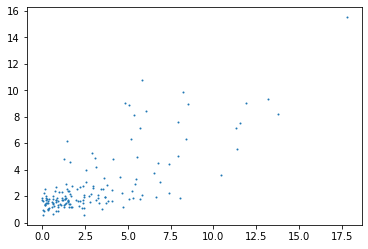

In [79]:
import matplotlib.pyplot as plt
plt.scatter(y_test_station, yhat_nn, s=1)

In [81]:
for skn in df_filtered['skn'].unique():
    model = Transfer_Model(inputs=C_GRID, outputs='data_in')
    model.fine_tune(
        df_filtered, fold=1, skn=skn, retrain_full=True, model_path='models/testing.hdf5',
        epochs=300,
        batch_size=64,
        stopping_patience=10,
        lr=0.0001,
        lr_factor=0.95,
        lr_patience=8,
        verbose=0,
        validation_split=0.1
    )

    _,_,_,_, x_train_station, x_test_station, y_train_station, y_test_station = model.train_test_split(df_filtered, fold=1, fine_tune=True, skn=skn)

    yhat_nn = model.model.predict(x_test_station)
    rmse_nn = mean_squared_error(y_test_station, yhat_nn, squared=False)
    # rmse_nn = mean_squared_error(np.power(np.e, Ytest_station), np.power(np.e, yhat_station), squared=False)

    # Linear Regression
    linear_regression = LinearRegression()
    linear_regression.fit(x_train_station, y_train_station)
    yhat_linear_regression = linear_regression.predict(x_test_station)
    rmse_lr = mean_squared_error(y_test_station, yhat_linear_regression, squared=False)
    # rmse_lr = mean_squared_error(np.power(np.e, Ytest_station), np.power(np.e, yhat_linear_regression), squared=False)

    print('Fold {}\n LR: {:.10f}, NN: {:.10f}'.format(1, rmse_lr, rmse_nn))

Epoch 1/13
10/10 [==============================] - 0s 5ms/step - loss: 20.4533 - root_mean_squared_error: 4.5225
Epoch 2/13
10/10 [==============================] - 0s 4ms/step - loss: 19.1048 - root_mean_squared_error: 4.3709
Epoch 3/13
10/10 [==============================] - 0s 5ms/step - loss: 19.2093 - root_mean_squared_error: 4.3828
Epoch 4/13
10/10 [==============================] - 0s 5ms/step - loss: 20.8914 - root_mean_squared_error: 4.5707
Epoch 5/13
10/10 [==============================] - 0s 5ms/step - loss: 20.3753 - root_mean_squared_error: 4.5139
Epoch 6/13
10/10 [==============================] - 0s 5ms/step - loss: 20.6152 - root_mean_squared_error: 4.5404
Epoch 7/13
10/10 [==============================] - 0s 4ms/step - loss: 18.1545 - root_mean_squared_error: 4.2608
Epoch 8/13
10/10 [==============================] - 0s 4ms/step - loss: 19.0631 - root_mean_squared_error: 4.3661
Epoch 9/13
10/10 [==============================] - 0s 5ms/step - loss: 19.6403 - root_m